Przykład użycia autoenkodera do **filtracji szumu w obrazach**. Autoenkoder jest trenowany, aby rekonstruował obrazy bez szumu na podstawie zniekształconych danych wejściowych.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Definicja autoenkodera
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        
        # Enkoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Dekoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Sigmoid dla wartości w zakresie [0, 1]
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [26]:
# Przygotowanie danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten wejście (28x28 -> 784)
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [28]:
# Funkcja do dodawania szumu do obrazów
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clip(noisy_images, 0., 1.)  # Ograniczamy wartości do [0, 1]

In [30]:
# Inicjalizacja modelu, optymalizatora i funkcji straty
model = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Trening autoenkodera
num_epochs = 10
for epoch in range(num_epochs):
    for data, _ in train_loader:  # Ignorujemy etykiety
        noisy_data = add_noise(data)  # Dodanie szumu do danych wejściowych
        clean_data = data  # Oryginalne dane do nauki
        
        # Forward pass
        outputs = model(noisy_data)
        loss = criterion(outputs, clean_data)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0384
Epoch [2/10], Loss: 0.0347
Epoch [3/10], Loss: 0.0280
Epoch [4/10], Loss: 0.0245
Epoch [5/10], Loss: 0.0239
Epoch [6/10], Loss: 0.0241
Epoch [7/10], Loss: 0.0220
Epoch [8/10], Loss: 0.0214
Epoch [9/10], Loss: 0.0193
Epoch [10/10], Loss: 0.0204


In [34]:
# Zapisanie modelu
torch.save(model.state_dict(), 'denoising_autoencoder.pth')

In [36]:
# Testowanie modelu
test_data, _ = next(iter(train_loader))
noisy_test_data = add_noise(test_data)
denoised_output = model(noisy_test_data)

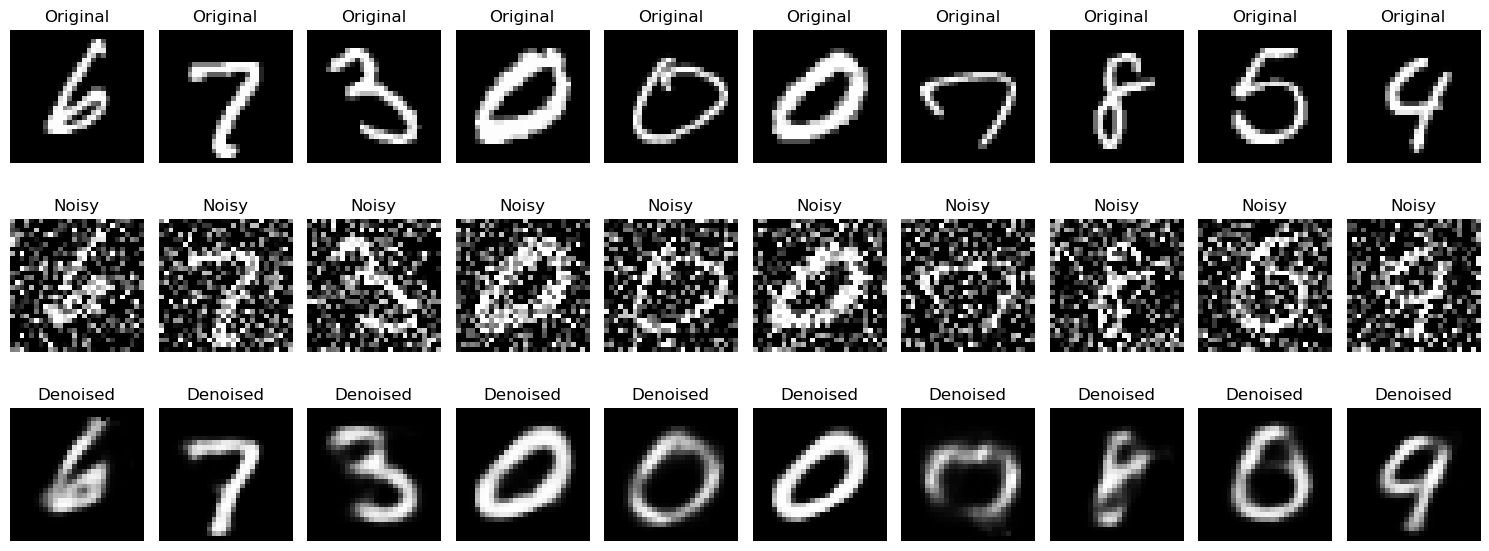

In [38]:
# Wizualizacja wyników
n = 10  # Liczba obrazów do wyświetlenia
plt.figure(figsize=(15, 6))
for i in range(n):
    # Oryginał
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_data[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Zaszumiony
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_test_data[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    
    # Odfiltrowany
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_output[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()